In [1]:
import torch
from agents.debn_ps import *
from environments.env_gridworld import *
from tqdm import tqdm 
from torchsummary import summary
from torch import tensor

import seaborn as sns
import matplotlib
%matplotlib inline 
import  matplotlib.pyplot as plt
from IPython.display import display, clear_output
sns.set()

from qumcmc.classical_mcmc_routines import * 
from qumcmc.quantum_mcmc_routines_qulacs import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling
from qumcmc.basic_utils import plot_multiple_bargraphs
from agents.enhanced_samplng import *

#### **PREPARE AGENT AND ENVIRONMENT**

In [2]:
# INTERACTION PARAMETERS #
#------------------------#
EPISODES = 50  # number of episodes for each agent 2000
MAX_STEPS_PER_TRIAL = 50  # number of allowed timesteps before reset 20000

#agent parameters
AGENT_NUMBER = 1
DEVICE = 'cpu'
AGENT_NAME = 'ebm'

GAMMA = 0.99 # discount factor
hidden_layers = 1 # number of hidden layers
hidden_units_layer = 5 # number of hidden units
NUM_HIDDEN = [int(round(hidden_units_layer))]*hidden_layers # list of hidden unit numbers list
DROPOUT = [0.]*hidden_layers # dropout rate list
LEARNING_RATE = 0.001 # learning rate
CAPACITY = 500 # size of the memory
BATCH_SIZE = 100 # size of the training batch for experience replay
REPLAY_TIME = 50 # the time interval between each experience replay
TARGET_UPDATE = 100 # update interval for the target network
SAVE_MODEL = False #set to true to save state dict

BETA_i = 0.001 # initial beta parameter for schedule
BETA_f = 0.08 # final beta parameter for schedule
SCHEDULE = 'htan' # name of the schedule
if SCHEDULE == 'htan':
    beta = np.tanh(np.linspace(BETA_i, BETA_f, EPISODES)) # tanh schedule
elif SCHEDULE =='lin':
    beta = np.linspace(BETA_i, BETA_f, EPISODES) # linear scchedule

# ENVIRONMENT PARAMETERS
ENV_NAME = 'gridworld' # environment name
DIMENSIONS = [4,4] # 2D grid of size [10,10]
env = TaskEnvironment(DIMENSIONS) #generate environment

## 'percept_size' depends on the encdoing 
percept_size_oneh = DIMENSIONS[0]*DIMENSIONS[1] #size of the percept space 
percept_size_twoh = DIMENSIONS[0]+DIMENSIONS[1] #size of the percept space

action_size = 4 # size of the action space

#action encoding
all_actions = torch.empty(0)
for i in range(action_size):
    a = torch.zeros((1, 1, action_size))
    a = a.new_full((1, 1, action_size), 0.)
    a[0, 0, i] = 1.
    all_actions = torch.cat((all_actions, a))

#percept encoding
def to_two_hot(percept, dim):
    """
    Two-hot encodes the 2D percept of positions.
    """
    two_hot = np.zeros(dim[0]+dim[1]) ##added
    two_hot[percept[0]] = 1
    two_hot[dim[0]+percept[1]] = 1
    return two_hot


#percept encoding
def to_one_hot(percept, dim):
    """
    One-hot encodes the 2D percept of positions.
    """
    one_hot = np.zeros(dim[0]*dim[1]) ## multiplied
    
    one_hot[dim[0]*percept[0] + percept[1]] = 1
    
    return one_hot    

# DEFINE AGENT           #
#------------------------#
agent = DEBNAgent(percept_size_twoh, action_size, all_actions, dim_hidden=NUM_HIDDEN, dropout_rate=DROPOUT,
                    device = DEVICE, learning_rate=LEARNING_RATE, capacity=CAPACITY, batch_size=BATCH_SIZE, replay_time=REPLAY_TIME,
                    target_update = TARGET_UPDATE, gamma = GAMMA, train_output_weights = False)

# EPISODES = 100
# MAX_STEPS_PER_TRIAL = 100
verbose = False
coords = []
# RUN TRAINING STEPS     #
#------------------------#
timesteps = []
for e in tqdm(range(EPISODES), desc= 'running episodes'):
    counter = 0
    #reset the environment
    percept = env.reset()
    coords.append(percept) ## coords stroing 
    # percept = to_one_hot(percept,DIMENSIONS)
    # percept = np.reshape(percept, [1, percept_size_oneh])
    percept = to_two_hot(percept,DIMENSIONS)
    percept = np.reshape(percept, [1, percept_size_twoh])
    percept = torch.Tensor(percept)
    reward = 0.
    done = False
    # for t in tqdm(range(1, MAX_STEPS_PER_TRIAL + 1), desc= 'runnnig episode . .. '+str(e) ):
    for t in range(1, MAX_STEPS_PER_TRIAL + 1):
        
        action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
        action = (action[0] == 1).nonzero().item()
        percept, reward, done, _ = env.step(action)
        coords.append(percept) ## coords storing 

        if verbose :  print('action : '+str( action) + ' percept : ' + str(percept) + ' reward : '+ str( reward))
        # percept = to_one_hot(percept, DIMENSIONS)
        # percept = np.reshape(percept, [1, percept_size_oneh])
        percept = to_two_hot(percept,DIMENSIONS)
        percept = np.reshape(percept, [1, percept_size_twoh])
        percept = torch.Tensor(percept)
        
        if t==MAX_STEPS_PER_TRIAL:
            reward = -1
            done = True
        if done:
            agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
            timesteps.append(t)
            break

    if e%100 == 0:
        if verbose : print("Average last 100 scores (timesteps per episode) the agent achieved at " + str(e) + ": ", np.mean(timesteps[-100:]))
        # save data to file

## get trajectory plotting data ##
xs = []; ys = []
for coord in coords: 
    xs.append(coord[0])
    ys.append(coord[1])

running episodes: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


##### Visualise trajectory

In [3]:
# ## visualise trajectory dynamically ## not very efficeint
# plt.figure(figsize=(12,12))
# for coord in tqdm(coords) :
#     plt.plot(coord[0], coord[1], 'o', 'r')
#     clear_output(wait= True)
#     plt.show()

In [4]:
# ## visualise spots visited  ##
# plt.figure(figsize=(12,12))
# # for coord in tqdm(coords) :
# #     plt.plot(xs, ys, '-o', 'r')
# plt.scatter(xs, ys )
# plt.show()

#### **TEST SAMPLING**

            MODEL : DEBN
Non-zero Interactions (J) : 60 / 136
Non-zero Bias (h) : 17 / 17
---------------------------------------------
Average Interaction Strength <|J|> :  0.14675196026899823
Average Bias Strength <|h|>:  0.15387738
alpha :  1.286351822827605
---------------------------------------------


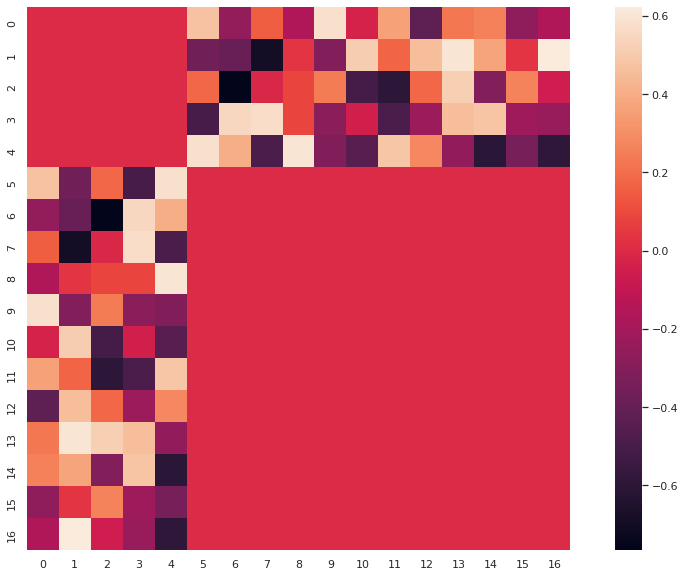

In [5]:
net_model = build_energy_model(agent.policy_net)
net_model.model_summary()

In [6]:
percept.shape[1]

8

In [7]:
NUM_HIDDEN, action_size

([5], 4)

#### Exact Sampling

In [10]:
# from agents.enhanced_samplng import RestrictedExactSampling
from typing import Union
from qumcmc.basic_utils import plot_bargraph_desc_order, plot_multiple_bargraphs
from qumcmc.prob_dist import DiscreteProbabilityDistribution, value_sorted_dict

# @dataclass
class RestrictedExactSampling(Exact_Sampling) :
     
    def __init__(self, model: IsingEnergyFunction, percept:str, dims: tuple, beta: float = 1) -> None:
          
          assert dims[2] == len(percept)
          self.model = model
          self.beta = beta
          self.dim_percept = len(percept)
          self.percept = percept
          self.dim_hidden = dims[0]
          self.dim_action = dims[1]
          self.dim_var = self.dim_action + self.dim_hidden
          self.all_configs = [f"{k:0{self.dim_var}b}"+percept for k in range(0, 2 ** (self.dim_var))]

          super().run_exact_sampling(self.beta)

    def get_boltzmann_distribution(
        self, beta:float = 1.0, sorted:bool = False, save_distribution:bool = False , return_dist:bool= True, plot_dist:bool = False
        ) -> dict :
        """ Get normalised boltzmann distribution over states 

            ARGS:
            ----
            beta : inverse temperature (1/ T)
            sorted  : if True then the states are sorted in in descending order of their probability
            save_dist : if True then the boltzmann distribution is saved as an attribute of this class -> boltzmann_pd 
            plot_dist : if True then plots histogram corresponding to the boltzmann distribution

            RETURNS:
            -------
            'dict' corresponding to the distribution
        """
        
        bltzmann_probs = dict( [ ( state, self.model.get_boltzmann_factor(state, beta= beta) ) for state in tqdm(self.all_configs, desc= 'running over all possible configurations') ] )
        partition_sum=np.sum(np.array(list(bltzmann_probs.values())))
        prob_vals=list(np.array(list(bltzmann_probs.values()))*(1./partition_sum))

        bpd= dict(zip(self.all_configs, prob_vals ))
        bpd_sorted_desc= value_sorted_dict( bpd, reverse=True )
        
        if save_distribution :
            self.boltzmann_pd = DiscreteProbabilityDistribution(bpd_sorted_desc)

        if plot_dist:
                plt.figure(2)
                plot_bargraph_desc_order(bpd_sorted_desc, label="analytical",plot_first_few=30); plt.legend()
        
        if return_dist :   
            if sorted: 
                return bpd_sorted_desc
            else :
                return bpd    
          
    def sampling_summary(self, plot_dist:bool=True):
        
        if self.exact_sampling_status :
            tmp = np.array(list(self.boltzmann_pd.values()))
            count_non_zero = len(tmp[tmp > 0.01])
            
            print("=============================================")
            print("     MODEL : "+str(self.name)+" |  beta : "+str(self.beta) )
            print("=============================================")
            
            
            print("Num Most Probable States : " + str( count_non_zero )   )
            print("Percept :", self.percept)
            # print("Entropy : " + str( self.get_entropy() ))
            print("Dims : ", (self.dim_hidden, self.dim_action, self.dim_percept) )
            print("---------------------------------------------")

            if plot_dist:
                plot_bargraph_desc_order(self.boltzmann_pd, label= 'Boltzmann Dist.', plot_first_few= count_non_zero)

        else:
            raise RuntimeError("Please Run Exact Sampling at any specified temperature first")


In [12]:
resm = RestrictedExactSampling(net_model, percept_to_str(percept), (NUM_HIDDEN[0], action_size, percept.shape[1]))

Running Exact Sampling | beta :  1


running over all possible configurations: 100%|██████████| 512/512 [00:00<00:00, 9133.25it/s]

saving distribution to model ...


In [17]:
d = {'a':0.1, 'a': 0.2, 'c': 0.4}
d['a']

0.2

In [15]:
resm.boltzmann_pd

{'01000111110001000': 0.23450152733765264,
 '01000111010001000': 0.0905634778638838,
 '01000101110001000': 0.0900550272206937,
 '01001101010001000': 0.06987782478145356,
 '01001001010001000': 0.04185857017585409,
 '01001111010001000': 0.036148346032045565,
 '01000101010001000': 0.03477886287917251,
 '01000110110001000': 0.027834331757454,
 '01010100110001000': 0.0264687002004497,
 '01011101010001000': 0.024330352064264094,
 '01010101110001000': 0.02262887920317577,
 '01001011010001000': 0.02165376618198677,
 '11000111110001000': 0.01814677115562708,
 '01001101110001000': 0.016303455048587656,
 '01100111110001000': 0.014986389781638193,
 '01010100010001000': 0.01416426244273311,
 '01000011110001000': 0.013638013938223134,
 '01010101010001000': 0.012109449326614128,
 '01000110010001000': 0.010749498805364223,
 '01000100110001000': 0.010689147881233709,
 '01001001110001000': 0.009766178603792443,
 '01001111110001000': 0.008433904982838929,
 '01100111010001000': 0.008081291998896347,
 '010

##### Classical Sampling

In [ ]:
rsmpc = RestrictedSampling(net_model, hidden_units_layer, action_size, percept_size_twoh, percept_to_str(percept))
clchn = rsmpc.run_classical_mcmc(100, verbose= False);
cdct = clchn.get_accepted_dict(normalize= True)

##### Quantum Sampling

In [ ]:
rsmpq = RestrictedSampling(net_model, hidden_units_layer, action_size, percept_size_twoh, percept_to_str(percept))
qchn = rsmpq.run_quantum_enhanced_mcmc(100, verbose=True)
qdct = qchn.get_accepted_dict(normalize=True)

current state:  MCMCState(hidden='10010', action='0000', state='00101000', accepted=True)


runnning quantum MCMC steps . ..: 100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


#### Checks

In [ ]:
percept, percept_to_str(percept)

(tensor([[0., 0., 1., 0., 1., 0., 0., 0.]]), '00101000')

In [ ]:
dict(zip(agent.all_actions, agent._choose_action(percept, return_prob_vals= True)))

{tensor([[1., 0., 0., 0.]]): 0.11285885811310369,
 tensor([[0., 1., 0., 0.]]): 0.28104685581766703,
 tensor([[0., 0., 1., 0.]]): 0.08993331113237765,
 tensor([[0., 0., 0., 1.]]): 0.5161609749368516}

In [ ]:
qdct

Counter({'000000101000': 0.4444444444444444,
         '100100101000': 0.1111111111111111,
         '100000101000': 0.1111111111111111,
         '010000101000': 0.2222222222222222,
         '110000101000': 0.1111111111111111})

In [ ]:
cdct

Counter({'010000101000': 0.18181818181818182,
         '010100101000': 0.09090909090909091,
         '011000101000': 0.09090909090909091,
         '101100101000': 0.09090909090909091,
         '000100101000': 0.09090909090909091,
         '111100101000': 0.09090909090909091,
         '011100101000': 0.09090909090909091,
         '110000101000': 0.18181818181818182,
         '110100101000': 0.09090909090909091})